# 1 - Data Wrangling & Visualisation
This notebook look at raw data, applies any necessary transformations and visualize it.

Creation date: 12.08.2017

In [3]:
import re

import joblib

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib notebook

from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import BaggingClassifier

import xgboost as xgb
from xgboost.sklearn import XGBClassifier

from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc

/home/arosa/.virtualenvs/ml/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [4]:
df = pd.read_csv("./data/No-show-Issue-Comma-300k.csv", index_col=None,
                 parse_dates=["AppointmentRegistration", "ApointmentData"], infer_datetime_format=True)

def camelcase_to_snakecase(name):
    s1 = re.sub('(.)([A-Z][a-z]+)', r'\1_\2', name)
    return re.sub('([a-z0-9])([A-Z])', r'\1_\2', s1).lower()

df.columns = df.columns.map(camelcase_to_snakecase)
df = df.rename(columns={"hiper_tension": "hipertension",
                        "sms__reminder": "sms_reminders",
                        "apointment_data": "apointment_date",
                        "awaiting_time": "days_delta"})

In [5]:
df.head(7)

,age,gender,appointment_registration,apointment_date,day_of_the_week,status,diabetes,alcoolism,hipertension,handcap,smokes,scholarship,tuberculosis,sms_reminders,days_delta
0,19,M,2014-12-16 14:46:25,2015-01-14,Wednesday,Show-Up,0,0,0,0,0,0,0,0,-29
1,24,F,2015-08-18 07:01:26,2015-08-19,Wednesday,Show-Up,0,0,0,0,0,0,0,0,-1
2,4,F,2014-02-17 12:53:46,2014-02-18,Tuesday,Show-Up,0,0,0,0,0,0,0,0,-1
3,5,M,2014-07-23 17:02:11,2014-08-07,Thursday,Show-Up,0,0,0,0,0,0,0,1,-15
4,38,M,2015-10-21 15:20:09,2015-10-27,Tuesday,Show-Up,0,0,0,0,0,0,0,1,-6
5,5,F,2014-06-17 06:47:27,2014-07-22,Tuesday,No-Show,0,0,0,0,0,0,0,1,-35
6,46,F,2015-06-19 19:53:58,2015-07-07,Tuesday,Show-Up,0,0,0,0,0,0,0,1,-18


In [6]:
df.status = df.status.map({"Show-Up": True, "No-Show": False})
df = df.rename(columns={"status": "showed"})

In [7]:
for feature in ["diabetes", "alcoolism", "hipertension", "handcap",
                "smokes", "scholarship", "tuberculosis", "sms_reminders"]:
    print(df[feature].unique())        

[0 1]
[0 1]
[0 1]
[0 1 2 3 4]
[0 1]
[0 1]
[0 1]
[0 1 2]


In [8]:
df["ln_days_delta"] = np.log(-df.days_delta)
df = df.drop("days_delta", axis=1)

In [9]:
boolean_features = ["diabetes", "alcoolism", "hipertension", "smokes", "scholarship", "tuberculosis"]
categorical_features = ["gender", "handcap"]

for feature in boolean_features:
    df[feature] = df[feature].astype("bool")

for feature in categorical_features:
    df[feature] = df[feature].astype("category")
    
df.day_of_the_week= df.day_of_the_week.astype("category", categories=["Monday","Tuesday","Wednesday",
                                                  "Thursday", "Friday", "Saturday", "Sunday"])

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300000 entries, 0 to 299999
Data columns (total 15 columns):
age                         300000 non-null int64
gender                      300000 non-null category
appointment_registration    300000 non-null datetime64[ns]
apointment_date             300000 non-null datetime64[ns]
day_of_the_week             300000 non-null category
showed                      300000 non-null bool
diabetes                    300000 non-null bool
alcoolism                   300000 non-null bool
hipertension                300000 non-null bool
handcap                     300000 non-null category
smokes                      300000 non-null bool
scholarship                 300000 non-null bool
tuberculosis                300000 non-null bool
sms_reminders               300000 non-null int64
ln_days_delta               300000 non-null float64
dtypes: bool(7), category(3), datetime64[ns](2), float64(1), int64(2)
memory usage: 14.3 MB


In [11]:
df.head()

,age,gender,appointment_registration,apointment_date,day_of_the_week,showed,diabetes,alcoolism,hipertension,handcap,smokes,scholarship,tuberculosis,sms_reminders,ln_days_delta
0,19,M,2014-12-16 14:46:25,2015-01-14,Wednesday,True,False,False,False,0,False,False,False,0,3.367296
1,24,F,2015-08-18 07:01:26,2015-08-19,Wednesday,True,False,False,False,0,False,False,False,0,0.000000
2,4,F,2014-02-17 12:53:46,2014-02-18,Tuesday,True,False,False,False,0,False,False,False,0,0.000000
3,5,M,2014-07-23 17:02:11,2014-08-07,Thursday,True,False,False,False,0,False,False,False,1,2.708050
4,38,M,2015-10-21 15:20:09,2015-10-27,Tuesday,True,False,False,False,0,False,False,False,1,1.791759


In [12]:
df.describe(include="all")

,age,gender,appointment_registration,apointment_date,day_of_the_week,showed,diabetes,alcoolism,hipertension,handcap,smokes,scholarship,tuberculosis,sms_reminders,ln_days_delta
count,300000.000000,300000,300000,300000,300000,300000,300000,300000,300000,300000.0,300000,300000,300000,300000.000000,300000.000000
unique,NaN,2,295425,534,7,2,2,2,2,5.0,2,2,2,NaN,NaN
top,NaN,F,2015-04-15 14:19:34,2014-10-22 00:00:00,Wednesday,True,False,False,False,0.0,False,False,False,NaN,NaN
freq,NaN,200505,9,759,63495,209269,276610,292497,235233,294403.0,284289,270931,299865,NaN,NaN
first,NaN,NaN,2013-05-29 15:14:11,2014-01-02 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,NaN,NaN,2015-12-29 12:08:58,2015-12-30 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,37.808017,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.574173,2.059843
std,22.809014,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.499826,1.141698
min,-2.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000
25%,19.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,1.386294


In [13]:
# considering the few (6) cases of negative age as typos
df.loc[df.age < 0, "age"] = -df.loc[df.age < 0, "age"]

### Plot Data Distributions

<IPython.core.display.Javascript object>


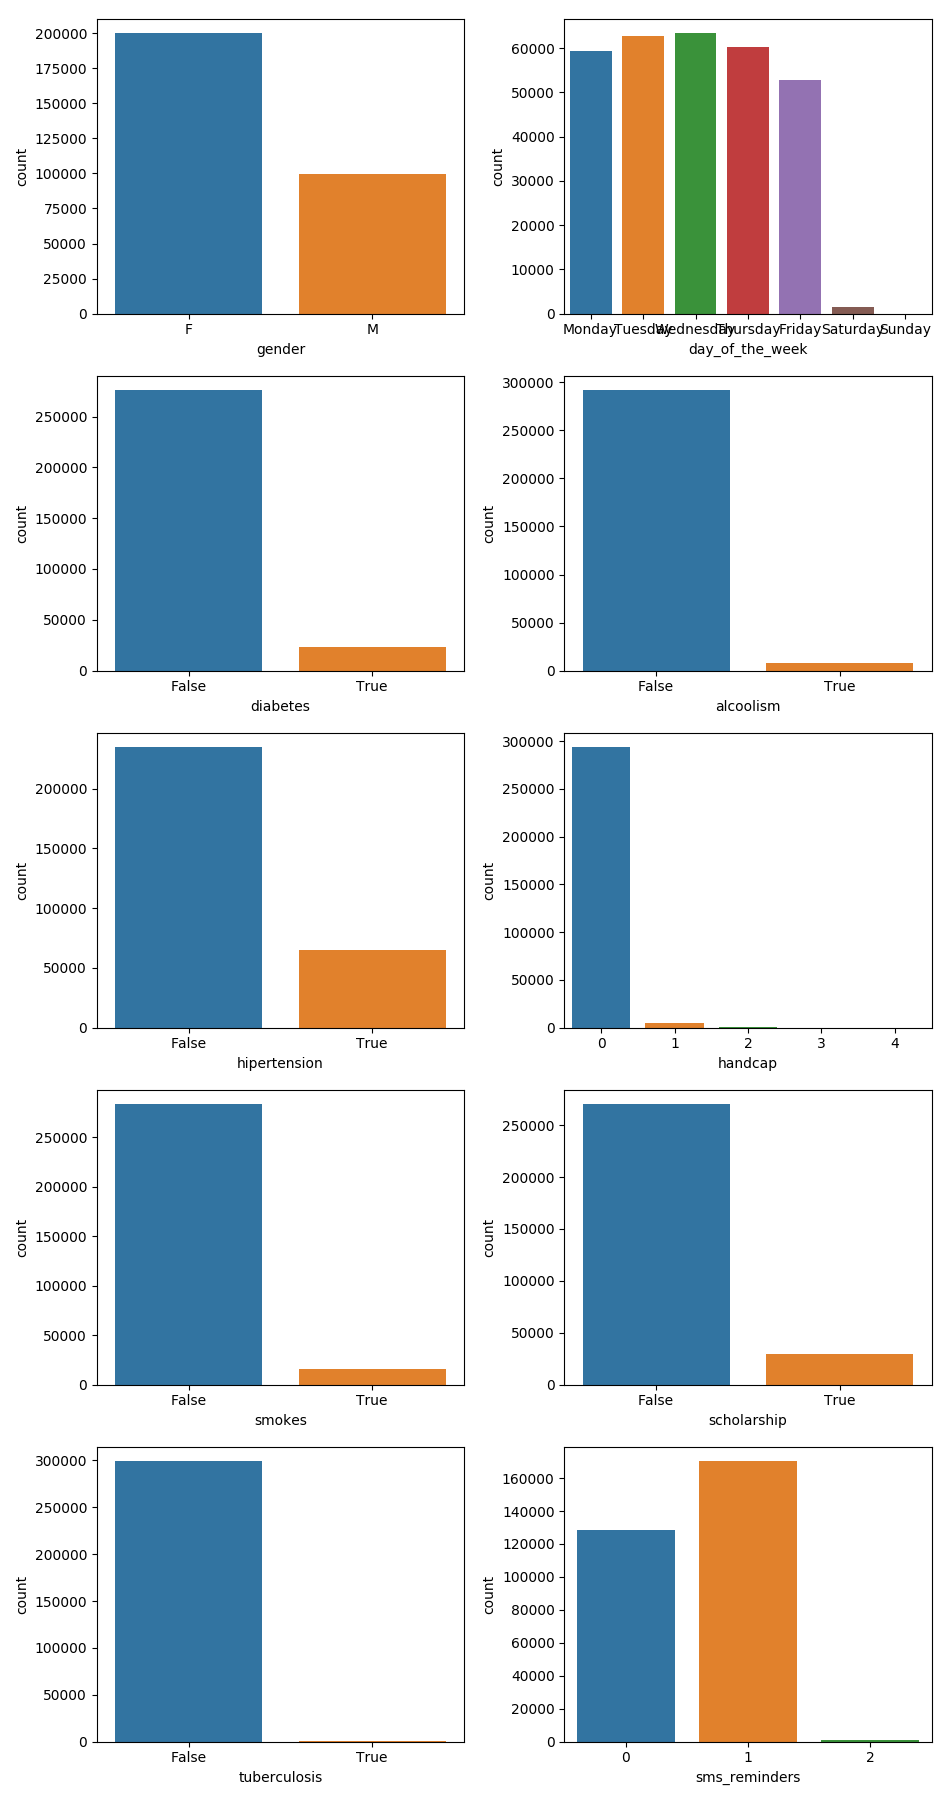

In [14]:
plt.figure(figsize=(9.5,18))
gs = gridspec.GridSpec(5, 2)

features = list(df.select_dtypes(include=["category", "bool"]).columns.drop("showed"))
features.append("sms_reminders")

for i, feature in enumerate(features):
    ax = plt.subplot(gs[(i // 2), (i % 2)])
    sns.countplot(x=feature, data=df, ax=ax)

plt.tight_layout()
plt.show()

<IPython.core.display.Javascript object>


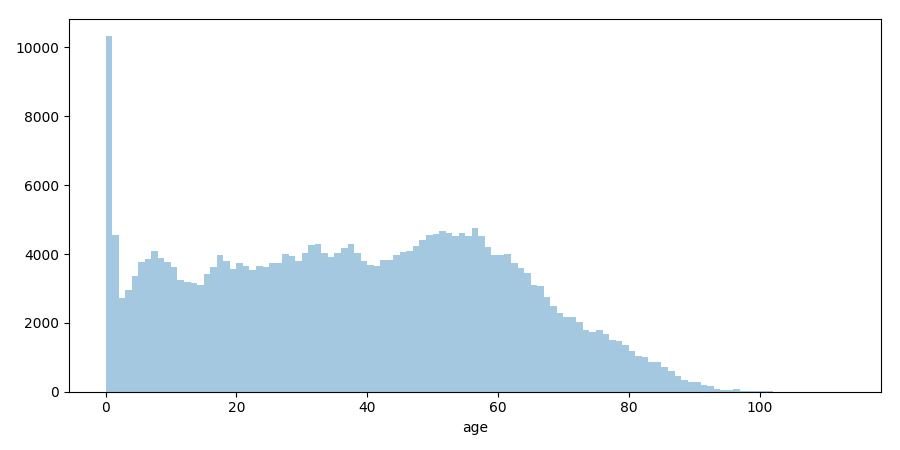

In [15]:
plt.figure(figsize=(9, 4.5))
sns.distplot(df.age, bins=113, kde=False)
plt.tight_layout()
plt.show()

<IPython.core.display.Javascript object>


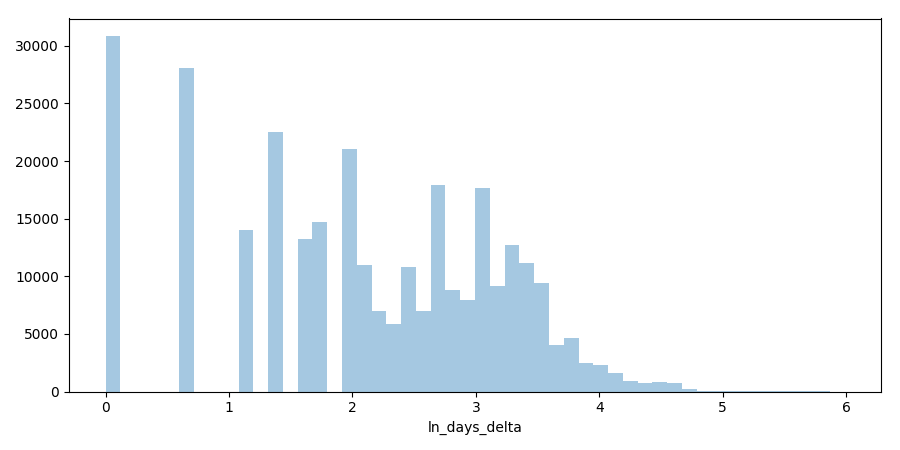

In [16]:
plt.figure(figsize=(9, 4.5))
sns.distplot(df.ln_days_delta, kde=False)
plt.tight_layout()
plt.show()

### Plot Show/No-Show Distribution

<IPython.core.display.Javascript object>


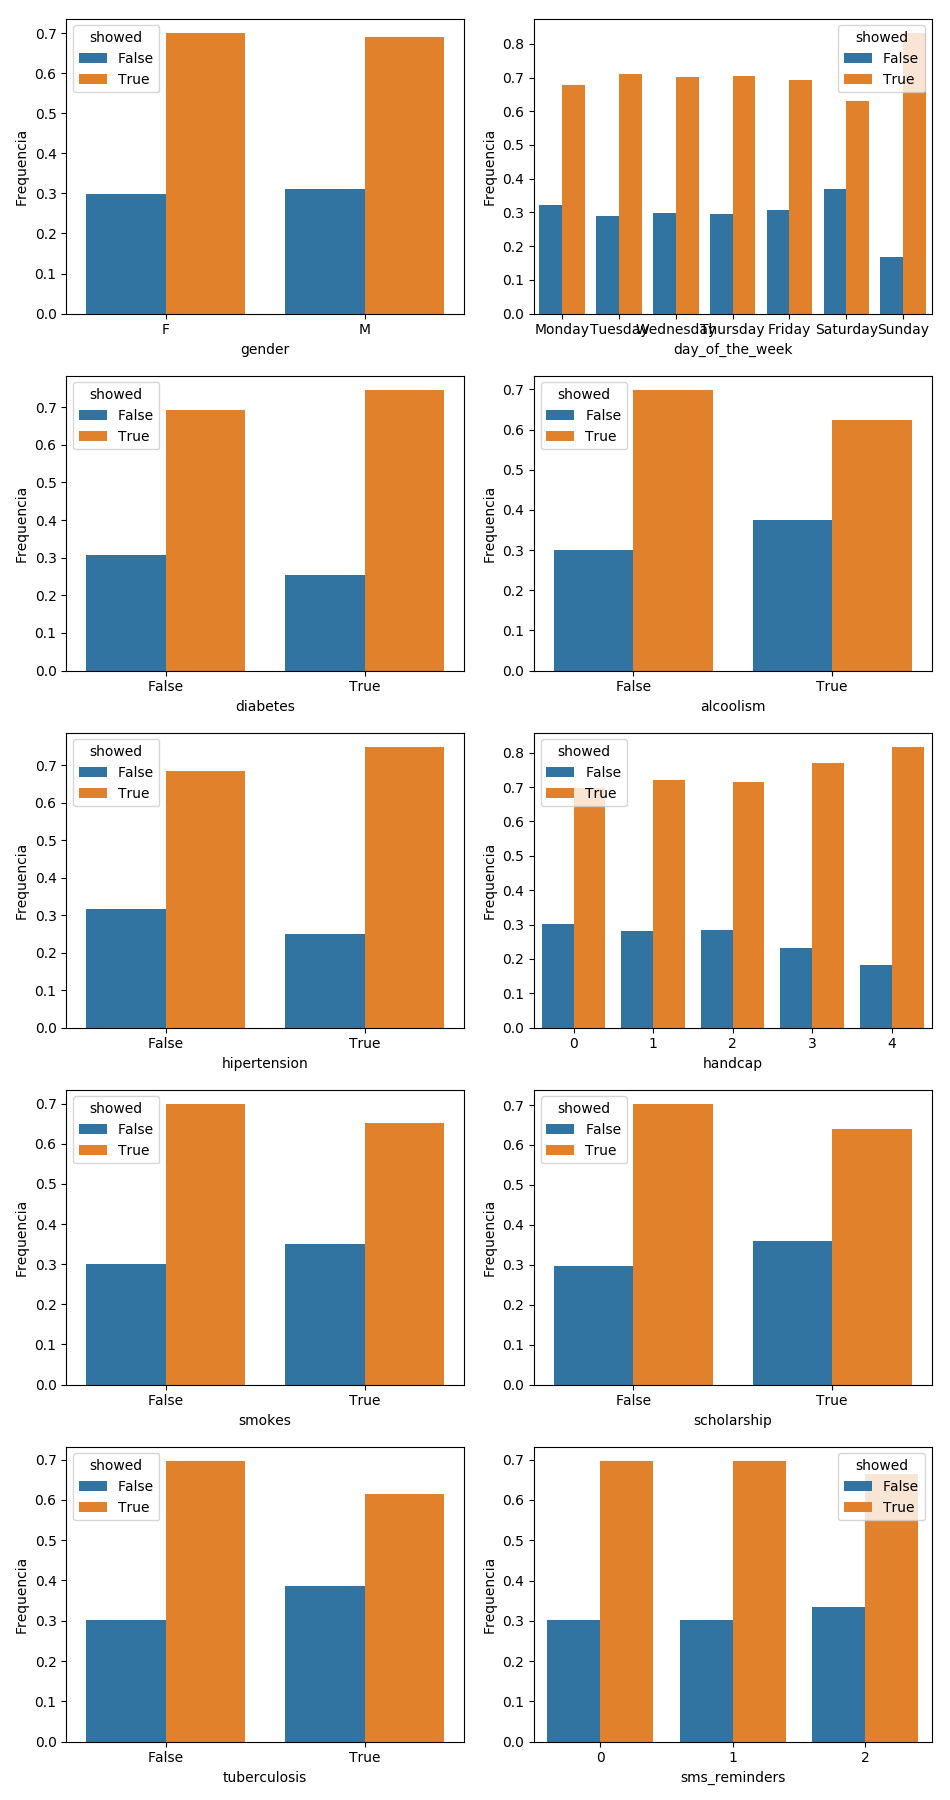

In [17]:
plt.figure(figsize=(9.5,18))
gs = gridspec.GridSpec(5, 2)

features = list(df.select_dtypes(include=["category", "bool"]).columns.drop("showed"))
features.append("sms_reminders")



for i, feature in enumerate(features):
    
    feature_counts = (df.groupby([feature])["showed"]
                            .value_counts(normalize=True)
                            .rename('frequence')
                            .reset_index()
                            .sort_values(feature))
    
    ax = plt.subplot(gs[(i // 2), (i % 2)])
    plot = sns.barplot(x=feature, y="frequence", hue="showed",
                       data=feature_counts, ax=ax)
    plot.set_ylabel("Frequencia")
    plot.set_xlabel(feature)

plt.tight_layout()
plt.show()

<IPython.core.display.Javascript object>


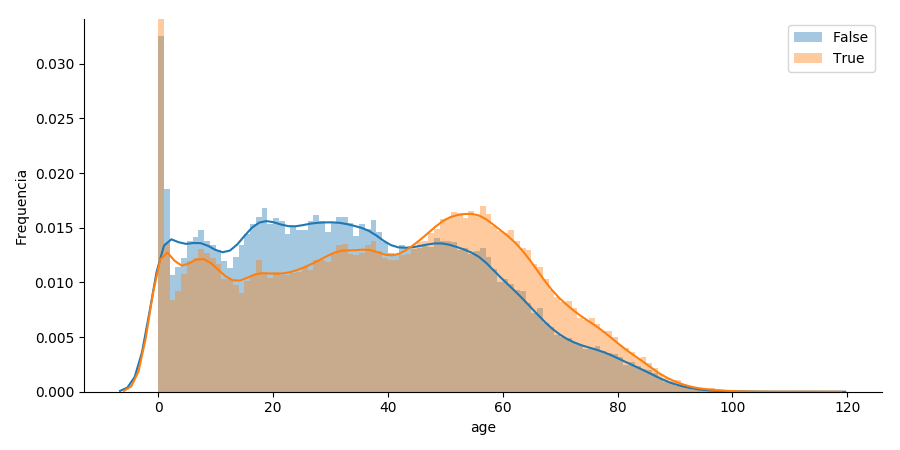

In [18]:
ax = sns.FacetGrid(df, hue="showed", size=4.5, aspect=2)
ax = ax.map(sns.distplot, "age", bins=113, kde=True)
ax.set_ylabels("Frequencia")
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

<IPython.core.display.Javascript object>


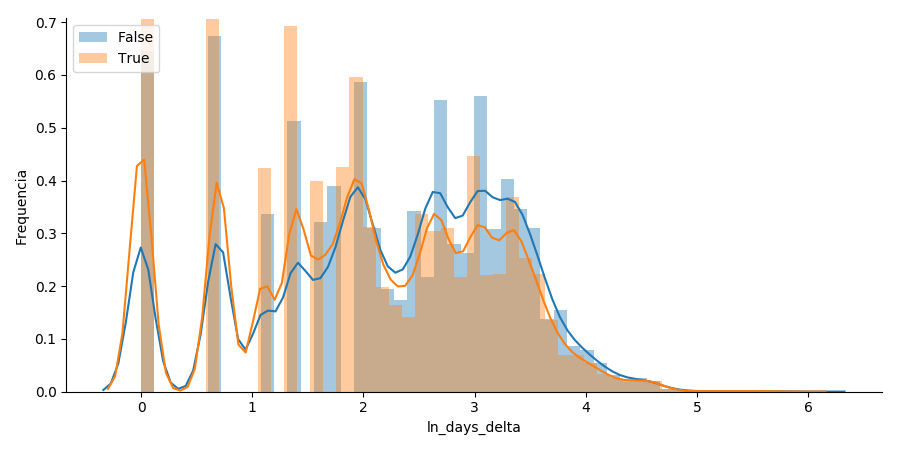

In [19]:
ax = sns.FacetGrid(df, hue="showed", size=4.5, aspect=2)
ax = ax.map(sns.distplot, "ln_days_delta", kde=True)
ax.set_ylabels("Frequencia")
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

In [20]:
# transformimg date values into sin/cos

# hour of registration
angle = df.appointment_registration.dt.hour * (2 * np.pi) / 24
df["registration_hour_sin"] = np.sin(angle)
df["registration_hour_cos"] = np.cos(angle)

# Day of the week (appointment)
angle = df.apointment_date.dt.dayofweek * (2 * np.pi) / 7
df["appointment_week_sin"] = np.sin(angle)
df["appointment_week_cos"] = np.cos(angle)

# Day of the month (appointment)
angle = df.apointment_date.dt.day * (2 * np.pi) / df.apointment_date.dt.days_in_month
df["appointment_month_sin"] = np.sin(angle)
df["appointment_month_cos"] = np.cos(angle)

# Day of the year (appointment)
angle = df.apointment_date.dt.dayofyear * (2 * np.pi) / 365 
df["appointment_year_sin"] = np.sin(angle)
df["appointment_year_cos"] = np.cos(angle)

# Dropping registration date, appointment date and day_of_the_week
df = df.drop(["day_of_the_week", "appointment_registration", "apointment_date"], axis=1)

In [21]:
df.head()

,age,gender,showed,diabetes,alcoolism,hipertension,handcap,smokes,scholarship,tuberculosis,sms_reminders,ln_days_delta,registration_hour_sin,registration_hour_cos,appointment_week_sin,appointment_week_cos,appointment_month_sin,appointment_month_cos,appointment_year_sin,appointment_year_cos
0,19,M,True,False,False,False,0,False,False,False,0,3.367296,-5.000000e-01,-0.866025,0.974928,-0.222521,0.299363,-0.954139,0.238673,0.971100
1,24,F,True,False,False,False,0,False,False,False,0,0.000000,9.659258e-01,-0.258819,0.974928,-0.222521,-0.651372,-0.758758,-0.741222,-0.671260
2,4,F,True,False,False,False,0,False,False,False,0,0.000000,1.224647e-16,-1.000000,0.781831,0.623490,-0.781831,-0.623490,0.746972,0.664855
3,5,M,True,False,False,False,0,False,False,False,1,2.708050,-9.659258e-01,-0.258819,0.433884,-0.900969,0.988468,0.151428,-0.587785,-0.809017
4,38,M,True,False,False,False,0,False,False,False,1,1.791759,-7.071068e-01,-0.707107,0.781831,0.623490,-0.724793,0.688967,-0.899631,0.436651


In [22]:
X = pd.get_dummies(df.drop(["showed"], axis=1)).values
y = df.showed.values

X = X.astype("float64")
y = y.astype("float64")

In [23]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=.3, random_state=7)
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=.5, random_state=7)

In [24]:
# col 0 = age, col 8 = ln_days_delta
scaler = StandardScaler()
scaler.fit(X_train[:, [0, 8]])
joblib.dump(scaler, "trained_models/scaler.p")

['trained_models/scaler.p']

In [25]:
X_train[:, [0, 8]] = scaler.transform(X_train[:, [0, 8]])
X_val[:, [0, 8]] = scaler.transform(X_val[:, [0, 8]])
X_test[:, [0, 8]] = scaler.transform(X_test[:, [0, 8]])

In [26]:
joblib.dump(X_train, "preprocessed_data/X_train.p")
joblib.dump(X_val, "preprocessed_data/X_val.p")
joblib.dump(X_test, "preprocessed_data/X_test.p")

joblib.dump(y_train, "preprocessed_data/y_train.p")
joblib.dump(y_val, "preprocessed_data/y_val.p")
joblib.dump(y_test, "preprocessed_data/y_test.p")

['preprocessed_data/y_test.p']

In [27]:
X.shape

(300000, 24)

In [60]:
clf = LogisticRegression(class_weight={0: 1.6530, 1:0.7168})
clf.fit(X_train, y_train)
clf.score(X_val, y_val)

0.57317777777777779

<IPython.core.display.Javascript object>


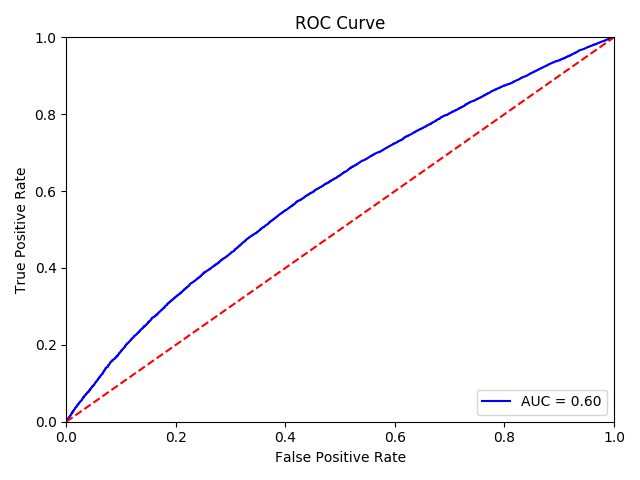

In [61]:
plt.figure()
fpr, tpr, thresh = roc_curve(y_val, clf.predict_proba(X_val)[:,1])
roc_auc = auc(fpr, tpr)

plt.title('ROC Curve')
plt.plot(fpr, tpr, 'b', label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([0,1])
plt.ylim([0,1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.tight_layout()
plt.show()

In [27]:
clf = XGBClassifier(n_estimators=400,
                    scale_pos_weight=((y_train == 0).sum() / y_train.sum()))
clf.silent = False

In [28]:
clf.fit(X_train, y_train)

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=400, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=0.43364281813216821, seed=0, silent=False,
       subsample=1)

In [29]:
clf.score(X_val, y_val)

0.58697777777777782

<IPython.core.display.Javascript object>


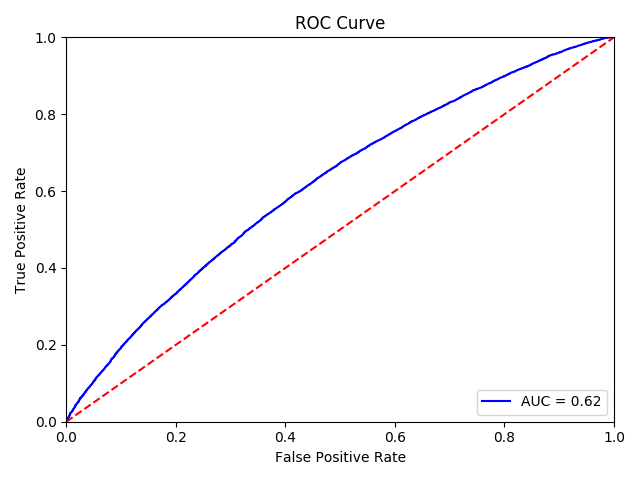

In [30]:
plt.figure()
fpr, tpr, thresh = roc_curve(y_test, clf.predict_proba(X_test)[:,1])
roc_auc = auc(fpr, tpr)

plt.title('ROC Curve')
plt.plot(fpr, tpr, 'b', label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([0,1])
plt.ylim([0,1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.tight_layout()
plt.show()

In [88]:
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Dropout

In [95]:
model = Sequential()
model.add(Dense(1, input_dim=X_train.shape[1]))
model.add(Activation('sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=["accuracy"])

In [96]:
class_weights = {0: 1.6530, 1:0.7168}
model.fit(X_train, y_train, batch_size=1024, epochs=10,
          validation_data=(X_test, y_test), class_weight=class_weights, verbose=1)

Train on 210000 samples, validate on 45000 samples
Epoch 1/10
210000/210000 [==============================] - 0s - loss: 0.7157 - acc: 0.4892 - val_loss: 0.6985 - val_acc: 0.5182
Epoch 2/10
210000/210000 [==============================] - 0s - loss: 0.6885 - acc: 0.5360 - val_loss: 0.6831 - val_acc: 0.5543
Epoch 3/10
210000/210000 [==============================] - 0s - loss: 0.6814 - acc: 0.5587 - val_loss: 0.6825 - val_acc: 0.5564
Epoch 4/10
210000/210000 [==============================] - 0s - loss: 0.6794 - acc: 0.5657 - val_loss: 0.6793 - val_acc: 0.5667
Epoch 5/10
210000/210000 [==============================] - 0s - loss: 0.6789 - acc: 0.5681 - val_loss: 0.6770 - val_acc: 0.5728
Epoch 6/10
210000/210000 [==============================] - 0s - loss: 0.6787 - acc: 0.5715 - val_loss: 0.6809 - val_acc: 0.5644
Epoch 7/10
210000/210000 [==============================] - 0s - loss: 0.6786 - acc: 0.5700 - val_loss: 0.6779 - val_acc: 0.5719
Epoch 8/10
210000/210000 [====================

<IPython.core.display.Javascript object>


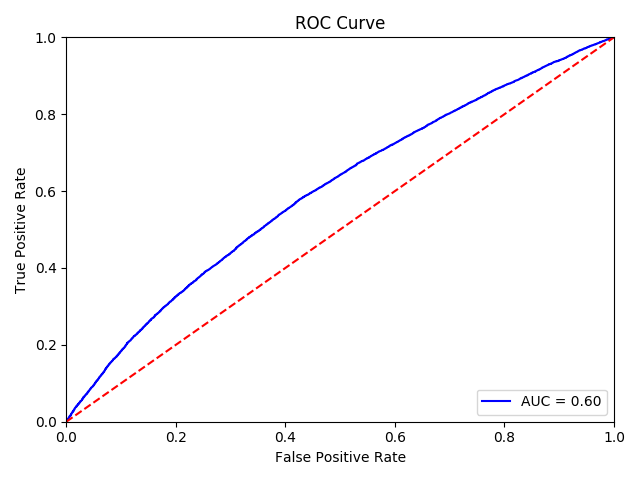

43872/45000 [============================>.] - ETA: 0s

In [97]:
plt.figure()
fpr, tpr, thresh = roc_curve(y_val, model.predict_proba(X_val)[:,0])
roc_auc = auc(fpr, tpr)

plt.title('ROC Curve')
plt.plot(fpr, tpr, 'b', label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([0,1])
plt.ylim([0,1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.tight_layout()
plt.show()